In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-seedlings-classification/sample_submission.csv
/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png
/kaggle/input/plant-seedlings-classification/test/0e8492cb1.png
/kaggle/input/plant-seedlings-classification/test/8d6acbe9b.png
/kaggle/input/plant-seedlings-classification/test/54b3afd58.png
/kaggle/input/plant-seedlings-classification/test/6049234e6.png
/kaggle/input/plant-seedlings-classification/test/82b5f4d33.png
/kaggle/input/plant-seedlings-classification/test/a0f37c726.png
/kaggle/input/plant-seedlings-classification/test/e0ec5b6a1.png
/kaggle/input/plant-seedlings-classification/test/1cfd91582.png
/kaggle/input/plant-seedlings-classification/test/456d507c0.png
/kaggle/input/plant-seedlings-classification/test/d6d31dcbe.png
/kaggle/input/plant-seedlings-classification/test/e1abb4ff9.png
/kaggle/input/plant-seedlings-classification/test/aa7d098d1.png
/kaggle/input/plant-seedlings-classification/test/e19673dc9.png
/kaggle/input/plant-seedlings-classif

# **Capstone Project -Machine Learning Portfolio**
**By Samy Mohsen**

* 1- Loading Libraries.
* 2- Exploratory Data Analysis.
* 3- Build Train and Test Loops.
* 4- Preparing data.
* 6- Train
* 7- Analyiz Results
* 8- Test Files Predction
* 9- Kaggle Supmission.

**1- Loading Libraries.**

In [1]:
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

import torch.utils.data
import torch.utils.data.distributed
from skimage.io import imread, imshow
from torch.utils.data import Dataset, DataLoader
import sys
import json
import csv
import os
import matplotlib.pyplot as plt
from skimage import io
import random

from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

**2- Exploratory Data Analysis.**

In [2]:
# Creat CSV for Train data named train.csv , As kaggle requires.
train_file="/kaggle/working/train.csv"

with open(train_file, 'w') as file:
    for dirname, _, filenames in os.walk('/kaggle/input/plant-seedlings-classification/train'):
        for filename in filenames:
            class_name = dirname
            class_name = class_name.replace('/kaggle/input/plant-seedlings-classification/train/', "")
            row = dirname + "/" + filename + ";" + class_name + ";" + filename
            file.write(row + '\n')

In [3]:
#creat Datafram for train data to explore.
col_name_train=['path','species','file']
df_train = pd.read_csv(train_file, delimiter=';', header=None)
df_train.columns = col_name_train

In [4]:
print(df_train.shape)
print(df_train.head(5))

(4750, 3)
                                                path            species  \
0  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
1  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
2  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
3  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
4  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   

            file  
0  4ae939d7d.png  
1  b8664f705.png  
2  628b08c82.png  
3  9ab3b61db.png  
4  086894274.png  


In [5]:
# Check for NaN Values 
df_train.isnull().values.any() 

False

In [6]:
print(df_train.describe())

                                                     path           species  \
count                                                4750              4750   
unique                                               4750                12   
top     /kaggle/input/plant-seedlings-classification/t...  Loose Silky-bent   
freq                                                    1               654   

                 file  
count            4750  
unique           4750  
top     4ae939d7d.png  
freq                1  


The number of train data set 4750 file number of classes is 12

In [7]:
dataset_classes = df_train['species'].unique()
print(f"Number of classes: {len(dataset_classes)}")

Number of classes: 12


Get some samples from our training set and see its shape.

<Figure size 432x288 with 0 Axes>

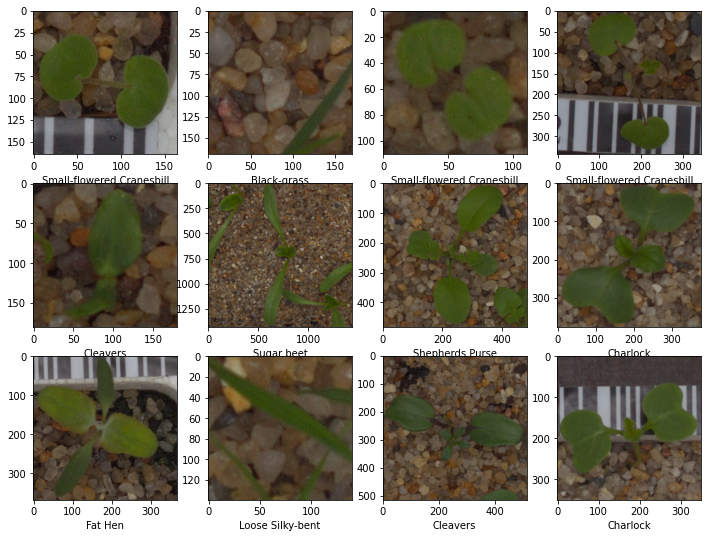

Image Shape:  (351, 351, 3)


In [8]:
fig = plt.figure()
plt.figure(figsize=(12,9))

for i in range(12):
    plt.subplot(3, 4, i+1)
    num = random.randint(0,len(df_train))
    file = df_train['path'][num]
    img = io.imread(file)
    plt.imshow(img)
    plt.xlabel(df_train['species'][num])
plt.show()

print("Image Shape: ", img.shape)

<Figure size 432x288 with 0 Axes>

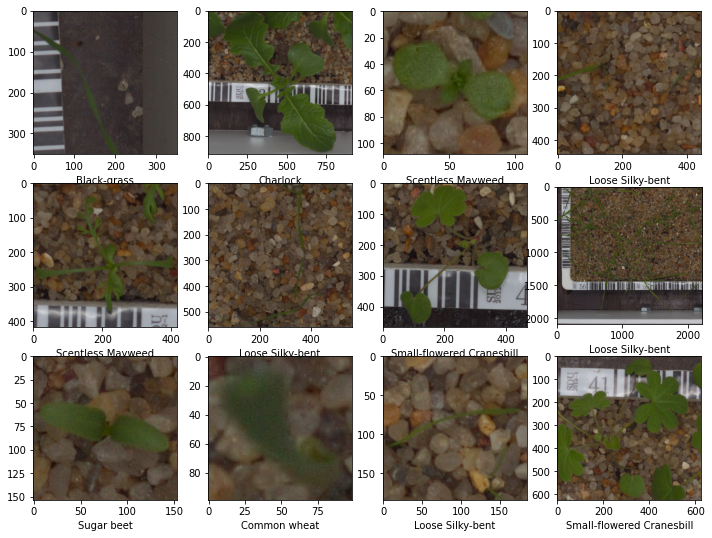

Image Shape:  (626, 626, 3)


In [9]:
fig = plt.figure()
plt.figure(figsize=(12,9))

for i in range(12):
    plt.subplot(3, 4, i+1)
    num = random.randint(0,len(df_train))
    file = df_train['path'][num]
    img = io.imread(file)
    plt.imshow(img)
    plt.xlabel(df_train['species'][num])
plt.show()

print("Image Shape: ", img.shape)

The samples are different in shape. we need to transform our data set later to fit in our model.

**3- Build Trainig**

In [41]:
#Our test function 
def test(model, test_loader, criterion, device):
 
    model.eval()
    running_loss=0
    running_corrects=0
    
    #testing loop
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs=model(inputs)
        loss=criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_loss += loss
        running_corrects += torch.sum(preds == labels.data).item()
       
       
    total_loss = running_loss / len(test_loader)
    total_acc = running_corrects / len(test_loader)
    
    #print( "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
         #   total_loss, running_corrects, len(test_loader), total_acc
     #   ))
    print('accuracy: {:.2f}'.format(100. * running_corrects / len(test_loader.dataset)))
    
    return model

In [11]:
#Our train function 

loss_value = []
accuracy = []

def train(model, train_loader, criterion, optimizer, epoch, device):

    #Searching if Cuda is available or just use CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.train()

    
    #training loop
    for e in range(epoch):
        running_loss=0
        correct=0
        for data, target in train_loader:
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()
            pred = model(data)             
            loss = criterion(pred, target)
            running_loss+=loss
            loss.backward()
            optimizer.step()
            pred=pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        print(f"Epoch {e}: Loss {running_loss/len(train_loader.dataset)}, Accuracy {100*(correct/len(train_loader.dataset))}%")
        loss_value.append(running_loss/len(train_loader))
        accuracy.append(correct/len(train_loader))
    
    
    return model

In [12]:
#Our pretraind model, I choosed resnet 18 because i'm more famillier wih it.
def create_model():
    '''
    TODO: Complete this function that initializes your model
          Remember to use a pretrained model
    '''
    
    
    #The dataset contains images from 12 Class.
    
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False   

    num_features=model.fc.in_features
    model.fc = nn.Sequential(
                   nn.Linear(num_features, 12))

    return model

**4- Preparing data**

In [13]:
#our dat transformers to run on our dataset .
#For train and test set(validition).
train_transform = transforms.Compose(
                                        [
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])


#we will use it later for our prediction that needed for kaggle submission
test_transform = transforms.Compose( 
                                             [
                                                 transforms.Resize((224,224)),
                                                 transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                             ])
    

In [14]:
#Since our labled data set contains 4750 img from 12 class we will split it for train set 80% and test 20%

data_dir = '/kaggle/input/plant-seedlings-classification/train'

dataset = datasets.ImageFolder(data_dir, transform=train_transform)

train_data, test_data = torch.utils.data.random_split(dataset, [3800, 950])

In [15]:
#I set the batch size to 32 and epoch to 5

batch_size=32
epoch = 5

# creat data loader for train and test data set
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [16]:
#to check if there is available GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on Device {device}")


model=create_model()

model= model.to(device)

#for cost function : since we need multiclass classification , we will use Cross-Entropy Loss/
# and Adam for optimization.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Running on Device cuda:0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**6- Model training**

In [17]:
train(model, train_loader, criterion, optimizer, epoch, device)

Epoch 0: Loss 0.059680573642253876, Accuracy 37.84210526315789%
Epoch 1: Loss 0.04083646461367607, Accuracy 61.68421052631579%
Epoch 2: Loss 0.03403239697217941, Accuracy 68.0%
Epoch 3: Loss 0.02979903295636177, Accuracy 71.26315789473684%
Epoch 4: Loss 0.026966528967022896, Accuracy 74.26315789473684%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
#evaluat model
test(model, test_loader, criterion, device)

accuracy: 75.16


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**7- Analyiz Results**

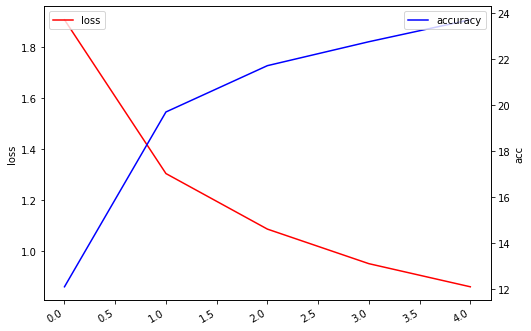

In [51]:
#plotting training Accuracy ,training loss with number of epoch.

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.set_ylabel("loss")
ax2.set_ylabel("acc")
ax1.plot(torch.Tensor(loss_value) , color = 'red', label = 'loss')
ax2.plot(accuracy, color = 'blue', label = 'accuracy')
fig.autofmt_xdate()

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

As we see here that increasing the number of epoch that increases the accuracy and decress the loss. There are other hyperprameters that will change the loss and the accuracy and over all the model performance.like batch size and the learning rate. 

**8- Test Files Predction (for kaggle submission)**

In [116]:
#creating test.csv file contains the test images that kaggle want to predict for submission

csv_pred="/kaggle/working/test.csv"

with open(csv_pred, 'w') as file:
    for dirname, _, filenames in os.walk('/kaggle/input/plant-seedlings-classification/test'):
        for filename in filenames:
            row = dirname + "/" + filename + ";" + filename
            file.write(row + '\n')

In [119]:
#creat dataframe for the test(prediction) files

column_names=['path','file']
df_pred = pd.read_csv(csv_pred, delimiter=';', header=None)
df_pred.columns = column_names

print(df_pred.shape)
print(df_pred.head(3))
df_pred.describe()
print(df_pred['path'][0])

(794, 2)
                                                path           file
0  /kaggle/input/plant-seedlings-classification/t...  fd87b36ae.png
1  /kaggle/input/plant-seedlings-classification/t...  0e8492cb1.png
2  /kaggle/input/plant-seedlings-classification/t...  8d6acbe9b.png
/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png


In [55]:
#save traiend model
torch.save(model.state_dict(), "checkpoint.pth")

In [70]:
#back to cpu for prediction
model = model.cpu()

In [71]:
#test prediction
img = Image.open('/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png')

In [72]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
input = test_transform(img)

In [74]:
valid_result = model(input.unsqueeze(0))

In [75]:
print(valid_result)

tensor([[-0.2012, -3.4791, -0.7113, -1.7551, -1.8756, -1.2926,  2.4710, -5.2790,
         -1.0481, -1.8116, -2.4244, -2.9115]], grad_fn=<AddmmBackward0>)


In [76]:
valid_result = valid_result.argmax()
valid_result

tensor(6)

In [80]:
print(dataset_classes[valid_result])

Maize


In [120]:
#take all the paths that in df_pred  and put it in loop to predict every image and put it in our list new list 
#of classes

class_list = []
for row in dataFrameTest["path"]:
        img = Image.open(row)
        model.eval()
        input = test_transform(img)
        valid_result = model(input.unsqueeze(0))
        valid_result = valid_result.argmax()
        class_list.append(dataset_classes[valid_result])

In [85]:
print(class_list)

['Maize', 'Shepherds Purse', 'Loose Silky-bent', 'Charlock', 'Maize', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Common wheat', 'Charlock', 'Maize', 'Shepherds Purse', 'Black-grass', 'Common wheat', 'Maize', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Maize', 'Loose Silky-bent', 'Shepherds Purse', 'Loose Silky-bent', 'Black-grass', 'Small-flowered Cranesbill', 'Common wheat', 'Loose Silky-bent', 'Charlock', 'Shepherds Purse', 'Maize', 'Charlock', 'Common Chickweed', 'Common wheat', 'Common Chickweed', 'Maize', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Black-grass', 'Loose Silky-bent', 'Shepherds Purse', 'Maize', 'Loose Silky-bent', 'Common wheat', 'Sugar beet', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Fat Hen', 'Small-flowered Cranesbill', 'Loose Silky-bent', 'Common wheat', 'Loose Silky-bent', 'Common wheat', 'Fat Hen', 'Maize', 'Shepherds Purse', 'Loose Silky-bent', 'Maize', 'Loose

In [86]:
len(class_list)
#the same len as our test images (kaggle requiers)

794

Now I will make another dataframe contains our predicted classes and merge it with df_pred. then will drop path column after that we have a df contains the name and the species as kaggle submission requiers. then save it to submission csv file to be ready for submit.

In [87]:

df_result = pd.DataFrame (class_list, columns = ['species'])

In [88]:
print(df_result.head())
df_result.dtypes

            species
0             Maize
1   Shepherds Purse
2  Loose Silky-bent
3          Charlock
4             Maize


species    object
dtype: object

In [89]:
df_result.species = df_result.species.astype(str)
dataFrameTest.path = dataFrameTest.path.astype(str)
dataFrameTest.file = dataFrameTest.file.astype(str)

In [90]:
new = pd.concat([dataFrameTest, df_result], axis=1, join='inner')

In [91]:
print(new.head())

                                                path           file  \
0  /kaggle/input/plant-seedlings-classification/t...  fd87b36ae.png   
1  /kaggle/input/plant-seedlings-classification/t...  0e8492cb1.png   
2  /kaggle/input/plant-seedlings-classification/t...  8d6acbe9b.png   
3  /kaggle/input/plant-seedlings-classification/t...  54b3afd58.png   
4  /kaggle/input/plant-seedlings-classification/t...  6049234e6.png   

            species  
0             Maize  
1   Shepherds Purse  
2  Loose Silky-bent  
3          Charlock  
4             Maize  


In [92]:
new.drop('path', axis=1, inplace=True)

In [93]:
print(new.head())
print(new.shape)

            file           species
0  fd87b36ae.png             Maize
1  0e8492cb1.png   Shepherds Purse
2  8d6acbe9b.png  Loose Silky-bent
3  54b3afd58.png          Charlock
4  6049234e6.png             Maize
(794, 2)


In [98]:
new.to_csv('submission.csv', index=False)

In [99]:
data = pd.read_csv("submission.csv")
print(data.shape)
print(data.head())

(794, 2)
            file           species
0  fd87b36ae.png             Maize
1  0e8492cb1.png   Shepherds Purse
2  8d6acbe9b.png  Loose Silky-bent
3  54b3afd58.png          Charlock
4  6049234e6.png             Maize
